# MADE: Masked Autencoder for Distribution Estimation

We will apply this algorithm to MNIST dataset for generating new handrwritten digits.

## Table of Contents

1. [Hyperparameters...](#1st)

<div id='1st'/>

## 1. Let us import some libraries and define some classes and functions

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab
import torch.distributions.binomial
import os
from torchvision.utils import save_image
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    # The init gets runned once an object (self) has been assigned this class:)
    def __init__(self, in_features, out_features, bias=True):
        # This initializes the nn.Linear class
        super().__init__(in_features, out_features, bias)
        
        # We initialize the mask as ones and it means we are not treating them as parameters!
        self.register_buffer('mask', torch.ones(out_features, in_features))

    # This is used to set the masks
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input.float(), self.mask.float() * self.weight.float(), self.bias.float())

In [3]:
class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=True):
        
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """

        super().__init__() # Initializes nn.Module
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"

        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]): # zip function goes through 2 iterable at the same time.
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net.extend([nn.Sigmoid()])
        self.net = nn.Sequential(*self.net)

        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings

        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.

    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency! YES! perfect.
        L = len(self.hidden_sizes) # number of layers

        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks # we repeat the process every num_masks.

        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])

        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])

        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        return self.net(x)

In [4]:
def run_epoch(split, upto=None):
    torch.set_grad_enabled(split=='train') # enable/disable grad for efficiency of forwarding test batches
    model.train() if split == 'train' else model.eval()
    nsamples = 1 if split == 'train' else args["samples"]
    x = xtr if split == 'train' else xte
    N,D = x.size() # N is the number of samples and D is the size of each sample
    			   # In our case 60.000x784 or 10.000x784 are the sizes.
    B = 100 # batch size, less than in the loaded code!
    nsteps = N//B if upto is None else min(N//B, upto) # enough steps so that we use the whole set
    lossfs = []
    for step in range(nsteps):

        # fetch the next batch of data
        xb = Variable(x[step*B:step*B+B])
        # xb = x[step*B:step*B+B]
        xb = xb.float()

        # print(xb.dtype)

        # get the logits, potentially run the same batch a number of times, resampling each time
        xbhat = torch.zeros_like(xb)
        for s in range(nsamples):
            # perform order/connectivity-agnostic training by resampling the masks
            if step % args["resample_every"] == 0 or split == 'test': # if in test, cycle masks every time
                model.update_masks()
            # forward the model
            xbhat += model(xb)
        xbhat /= nsamples

        # evaluate the binary cross entropy loss
        loss = F.binary_cross_entropy(xbhat, xb, size_average=False) / B # With logits before...
        lossf = loss.data.item()
        lossfs.append(lossf)

        # backward/update
        if split == 'train':
            opt.zero_grad()
            loss.backward()            
            opt.step()

    print("%s epoch average loss: %f" % (split, np.mean(lossfs)))

    if split == 'train':
        trainL[epoch] = np.mean(lossfs)

    if split == 'test':
        testL[epoch] = np.mean(lossfs)

In [5]:
np.round(0.7)

1.0

In [6]:
def sample_64(n):
    sample = torch.zeros((64,784))
    for r in range(64):
        image = np.zeros(28*28)
        image = torch.tensor(image)
        for i in range(28*28):
            # for idx, m in enumerate(model.named_modules()):
            #     print(idx, '->', m)
            prob = model(image) # Why not outputting between 0 and 1?¿?
            # print(prob[0:20])
            pixel = np.random.binomial(1, prob[i].detach().numpy())
            #pixel = int(np.round(prob[i].detach().numpy())) # clearer image
            image[i] = pixel
        sample[r] = image
    # Now image stores the sampled image using the regular order...
    path = 'samples/sample_' + str(n) + '.png'
    sample = sample.view(sample.size(0),1,28,28)
    save_image(sample, os.path.join(args["sample_dir"], 'fake_images-{}.png'.format(n)))

In [7]:
args = {
  'dtr_path': './data/x_train.npy',

  'dte_path': './data/x_test.npy',

  'hiddens': '500',

  'num_masks': 1,

  'resample_every': 20,

  'samples': 1, 
    
  'epochs': 100,
    
  'sample_dir': './samples'
}

In [8]:
# Hyper-parameters:
np.random.seed(42)
torch.manual_seed(42)
num_epochs = args["epochs"] # 150

## 2. Image Preprocessing

In [9]:
# IMAGE PREPROCESSING:

xtr = np.load(args["dtr_path"])
xte = np.load(args["dte_path"])
xtr = torch.from_numpy(xtr)
xte = torch.from_numpy(xte)

# Sizes: 60000x784, 10000x784, recall that 28*28 = 784

## 3. Model and Training

In [10]:
# MODEL and optimizer:

# Recall, map(fun,iter) applies the function to every element of the iter.
hidden_list = list(map(int, args["hiddens"].split(',')))
model = MADE(xtr.size(1), hidden_list, xtr.size(1), num_masks=args["num_masks"])
print("number of model parameters:",sum([np.prod(p.size()) for p in model.parameters()]))
# model.cuda()
model = model.float()

# set up the optimizer
opt = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-4) # Initially -3
# Here we apply weight decay to the learning rate, every 45 epochs
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

number of model parameters: 785284


epoch 0
test epoch average loss: 543.219250


/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 198.775618


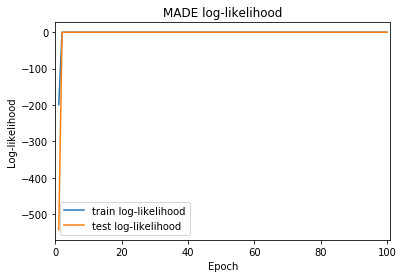

epoch 1
test epoch average loss: 136.284167


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 122.115443


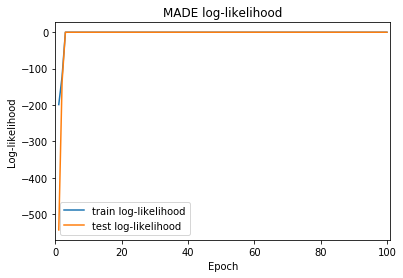

epoch 2
test epoch average loss: 111.423892


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 105.702997


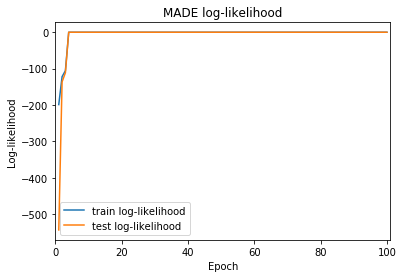

epoch 3
test epoch average loss: 101.478728


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 98.132271


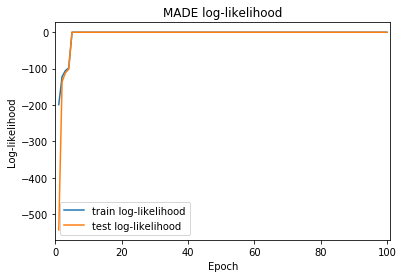

epoch 4
test epoch average loss: 96.322861


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 93.845877


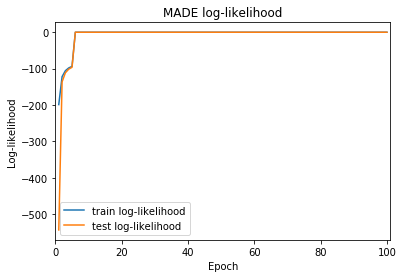

epoch 5
test epoch average loss: 93.188020


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 91.071874


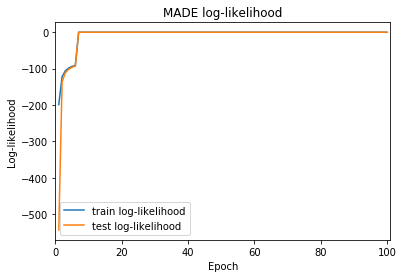

epoch 6
test epoch average loss: 91.072874


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 89.113641


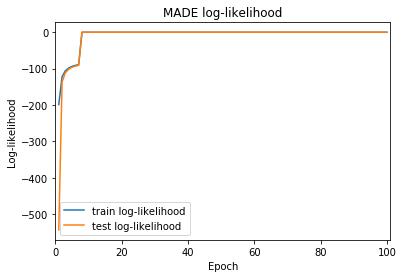

epoch 7
test epoch average loss: 89.544765


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 87.652955


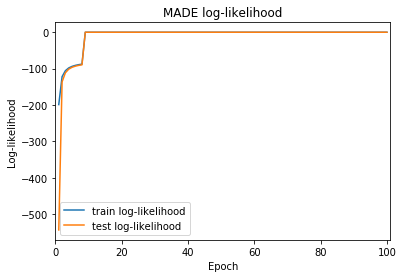

epoch 8
test epoch average loss: 88.382332


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 86.515187


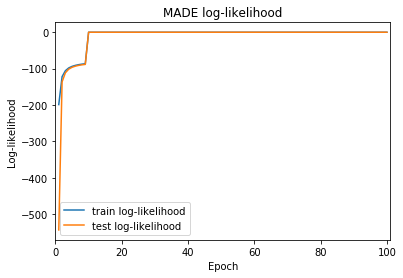

epoch 9
test epoch average loss: 87.478026


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 85.603464


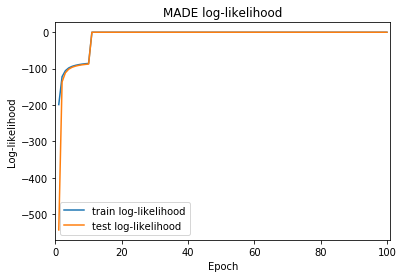

epoch 10
test epoch average loss: 86.789624


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 84.859173


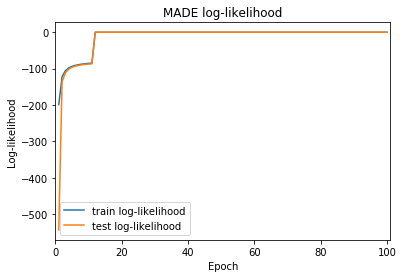

epoch 11
test epoch average loss: 86.251846


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 84.237046


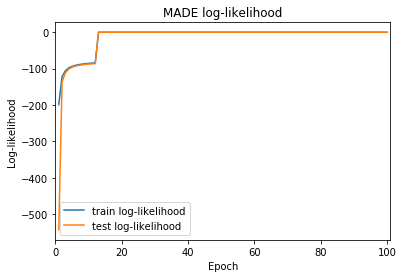

epoch 12
test epoch average loss: 85.814291


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 83.709105


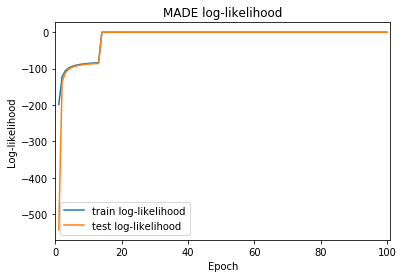

epoch 13
test epoch average loss: 85.457008


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 83.253347


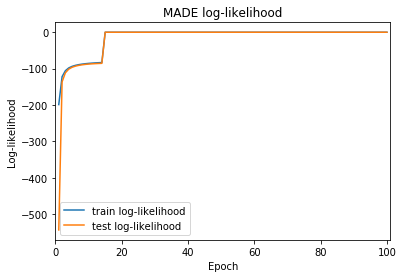

epoch 14
test epoch average loss: 85.150107


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 82.854428


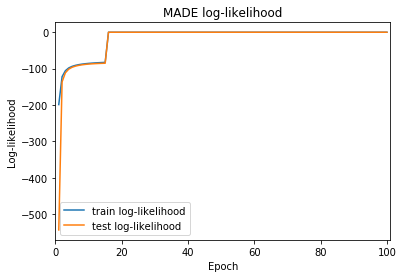

epoch 15
test epoch average loss: 84.873418


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 82.500881


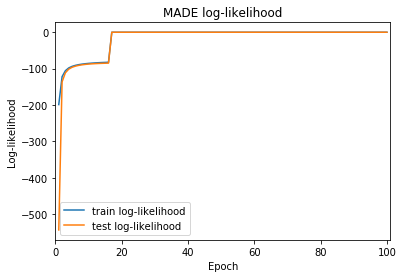

epoch 16
test epoch average loss: 84.623776


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 82.185788


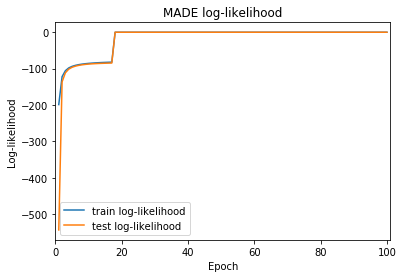

epoch 17
test epoch average loss: 84.407712


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 81.903993


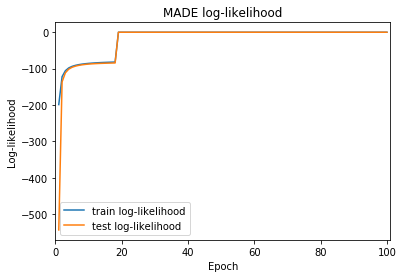

epoch 18
test epoch average loss: 84.214290


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 81.649672


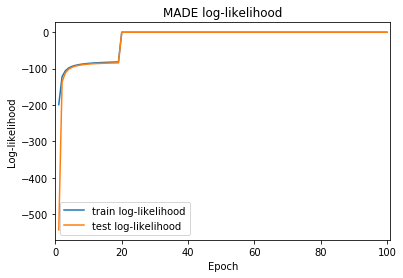

epoch 19
test epoch average loss: 84.031198


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 81.418551


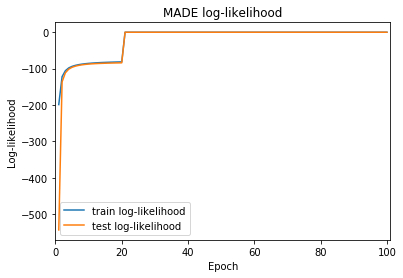

epoch 20
test epoch average loss: 83.885562


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 81.208506


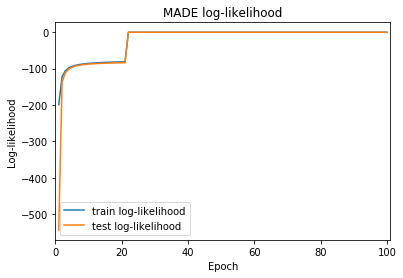

epoch 21
test epoch average loss: 83.753615


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 81.014281


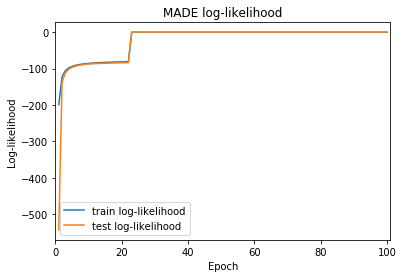

epoch 22
test epoch average loss: 83.637836


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 80.836441


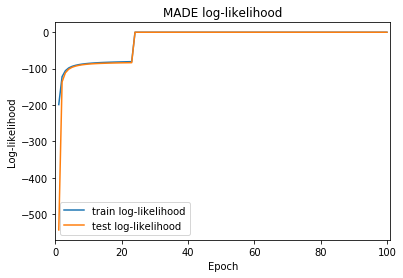

epoch 23
test epoch average loss: 83.540651


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 80.672146


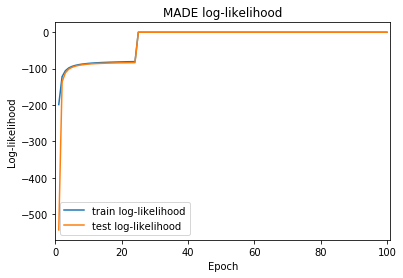

epoch 24
test epoch average loss: 83.442455


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 80.521052


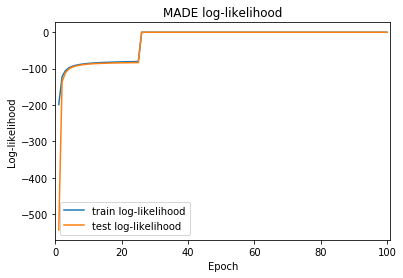

epoch 25
test epoch average loss: 83.360072


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 80.380875


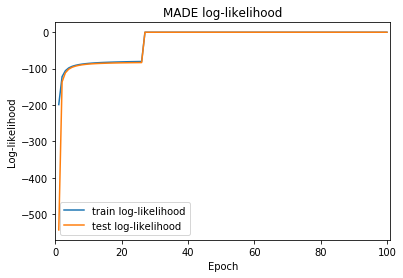

epoch 26
test epoch average loss: 83.275233


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 80.248090


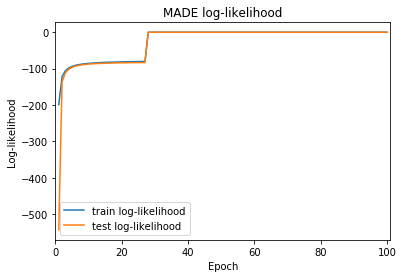

epoch 27
test epoch average loss: 83.207762


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 80.126362


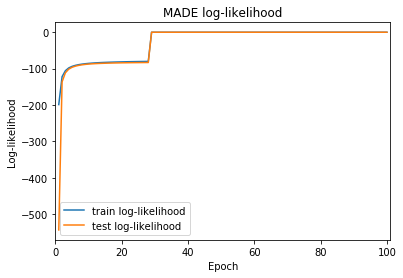

epoch 28
test epoch average loss: 83.136812


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 80.012243


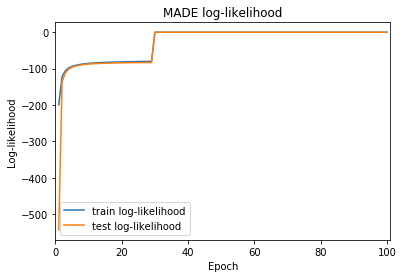

epoch 29
test epoch average loss: 83.071756


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.903756


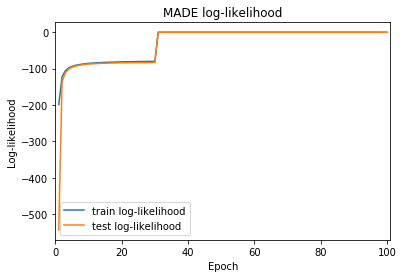

epoch 30
test epoch average loss: 82.999577


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.802794


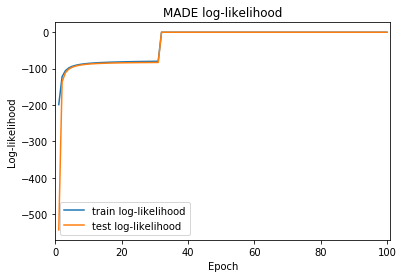

epoch 31
test epoch average loss: 82.940680


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.707614


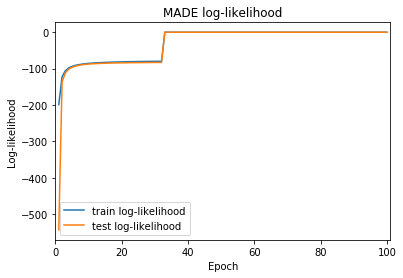

epoch 32
test epoch average loss: 82.885117


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.617954


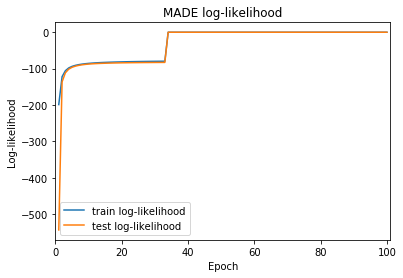

epoch 33
test epoch average loss: 82.821721


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.532907


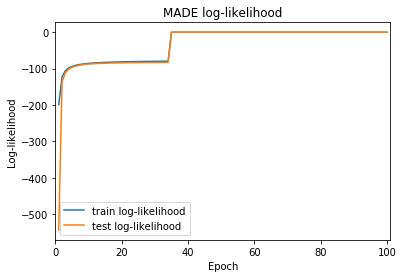

epoch 34
test epoch average loss: 82.771890


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.451803


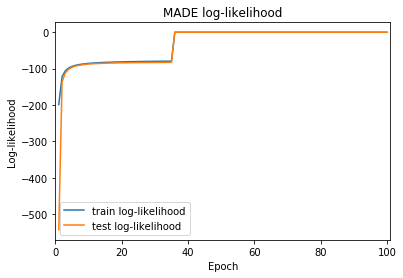

epoch 35
test epoch average loss: 82.724417


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.375700


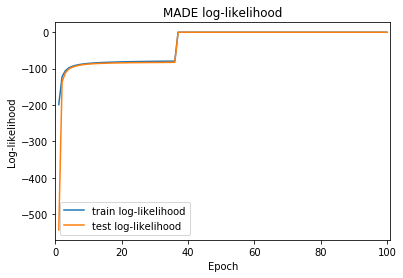

epoch 36
test epoch average loss: 82.664519


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.302630


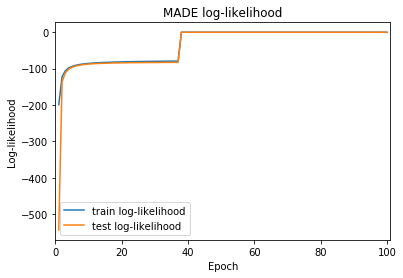

epoch 37
test epoch average loss: 82.619913


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.232845


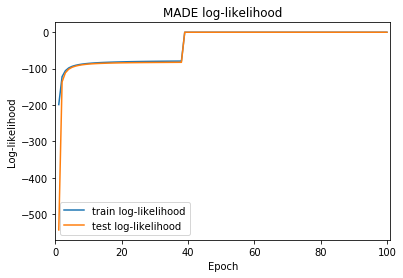

epoch 38
test epoch average loss: 82.575052


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.165976


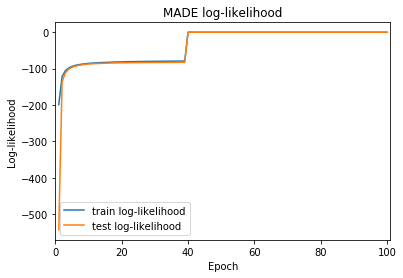

epoch 39
test epoch average loss: 82.532028


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.102547


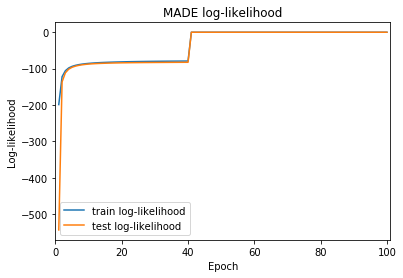

epoch 40
test epoch average loss: 82.501509


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 79.041503


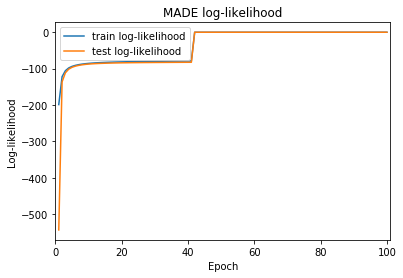

epoch 41
test epoch average loss: 82.461136


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 78.983281


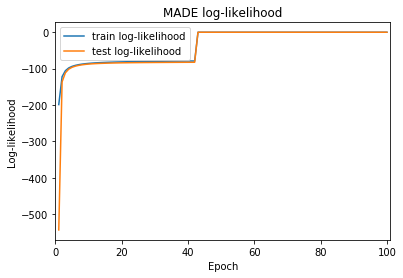

epoch 42
test epoch average loss: 82.428764


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 78.926059


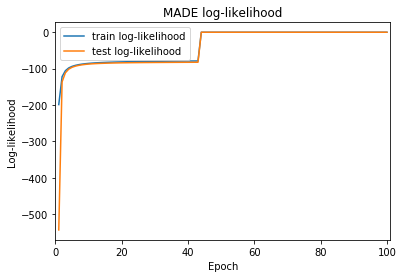

epoch 43
test epoch average loss: 82.399246


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 78.872675


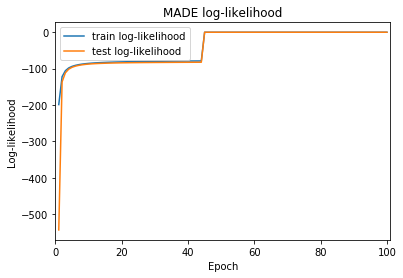

epoch 44
test epoch average loss: 82.357826


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 78.820494


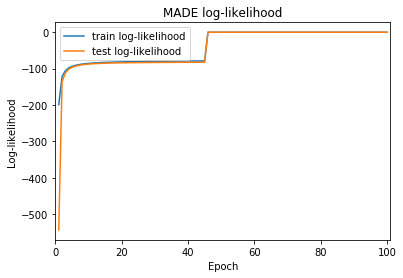

epoch 45
test epoch average loss: 82.322295


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.652559


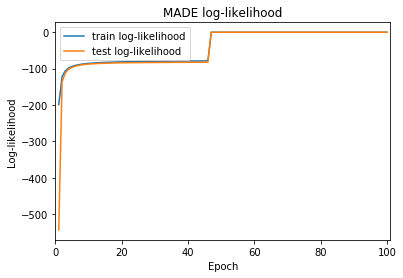

epoch 46
test epoch average loss: 80.888443


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.497537


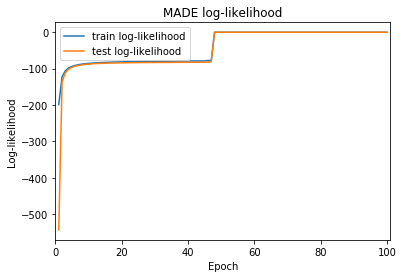

epoch 47
test epoch average loss: 80.844501


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.464891


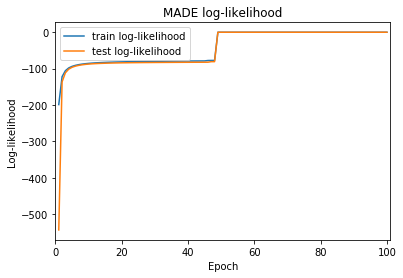

epoch 48
test epoch average loss: 80.823734


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.445004


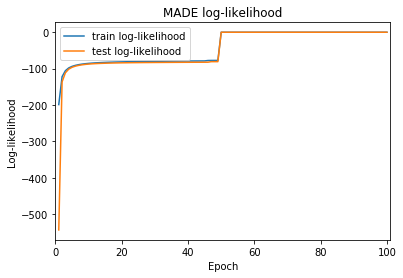

epoch 49
test epoch average loss: 80.810114


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.429646


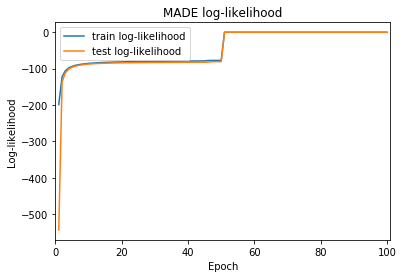

epoch 50
test epoch average loss: 80.798032


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.416702


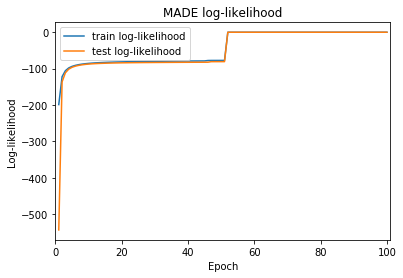

epoch 51
test epoch average loss: 80.787888


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.405288


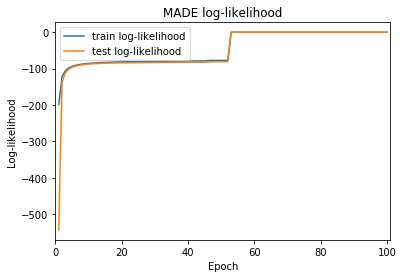

epoch 52
test epoch average loss: 80.779326


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.394764


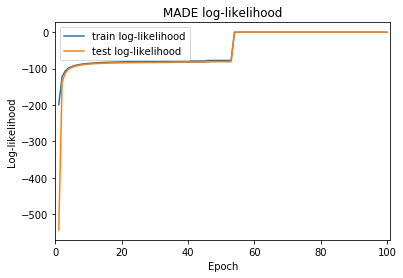

epoch 53
test epoch average loss: 80.771617


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.384902


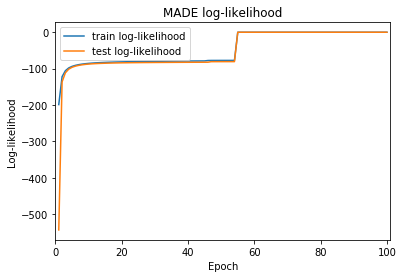

epoch 54
test epoch average loss: 80.765222


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.375591


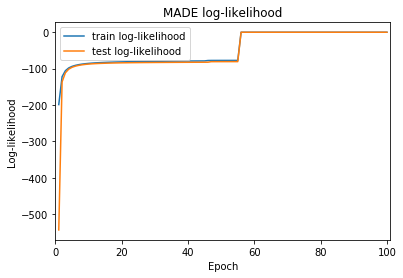

epoch 55
test epoch average loss: 80.758356


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.366670


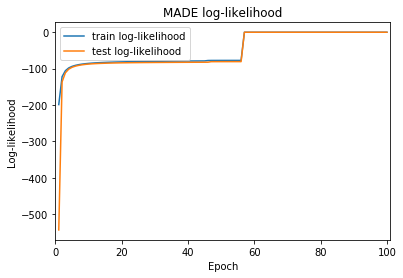

epoch 56
test epoch average loss: 80.752370


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.358082


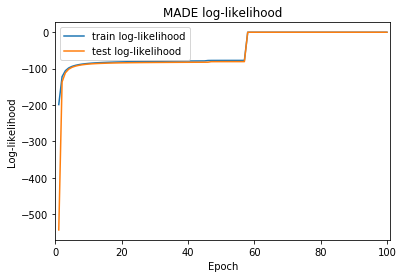

epoch 57
test epoch average loss: 80.746654


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.349762


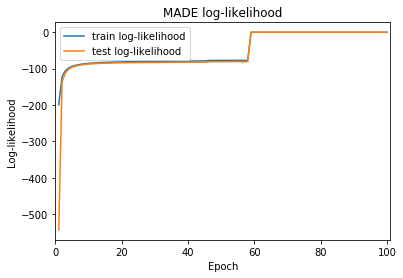

epoch 58
test epoch average loss: 80.740958


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.341585


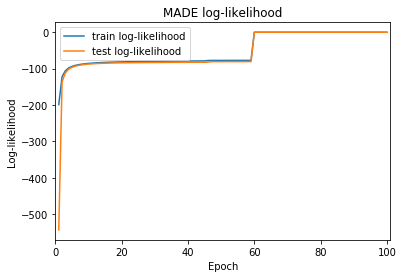

epoch 59
test epoch average loss: 80.735938


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.333675


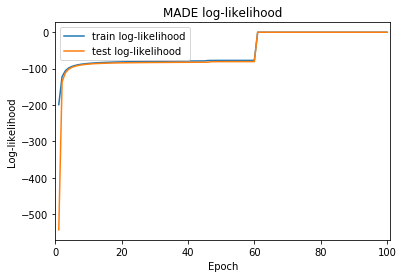

epoch 60
test epoch average loss: 80.730171


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.325881


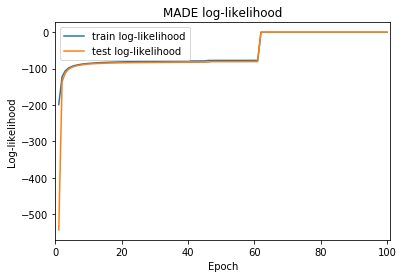

epoch 61
test epoch average loss: 80.725897


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.318258


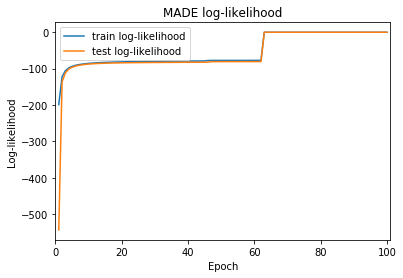

epoch 62
test epoch average loss: 80.719983


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.310725


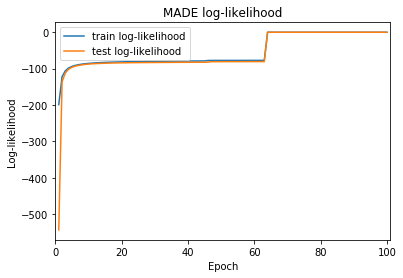

epoch 63
test epoch average loss: 80.715678


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.303266


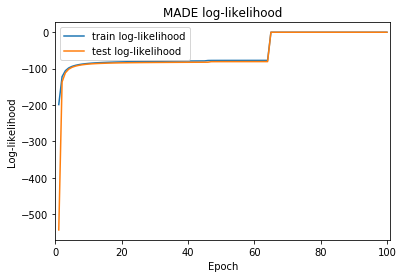

epoch 64
test epoch average loss: 80.710271


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.295999


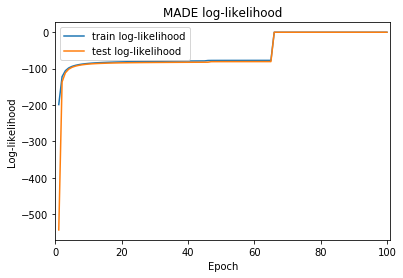

epoch 65
test epoch average loss: 80.705298


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.288797


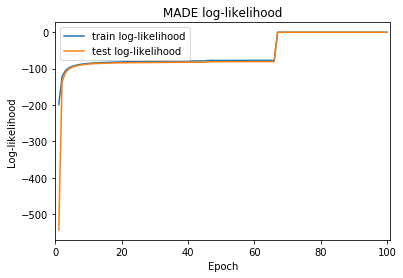

epoch 66
test epoch average loss: 80.700261


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.281657


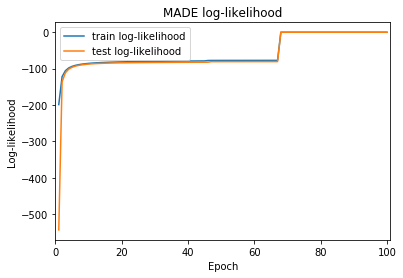

epoch 67
test epoch average loss: 80.696249


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.274647


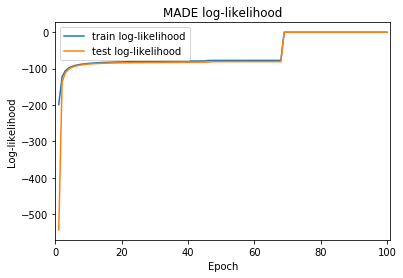

epoch 68
test epoch average loss: 80.690895


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.267768


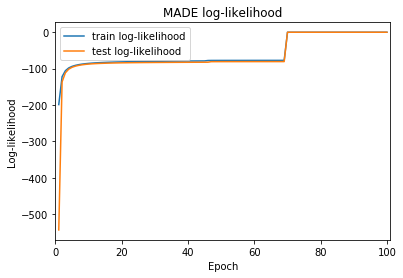

epoch 69
test epoch average loss: 80.686540


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.260874


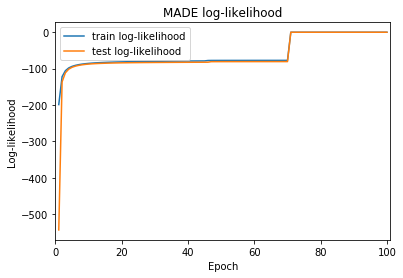

epoch 70
test epoch average loss: 80.682129


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.254179


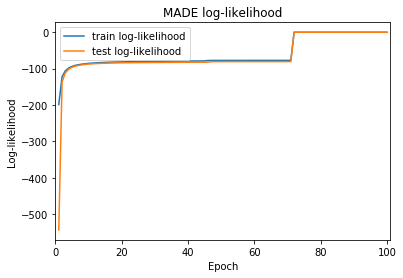

epoch 71
test epoch average loss: 80.677289


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.247496


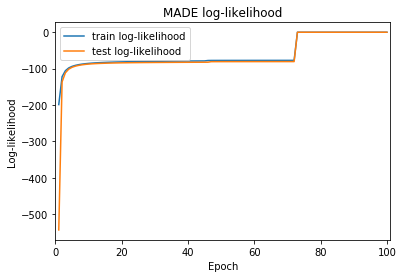

epoch 72
test epoch average loss: 80.672816


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.240686


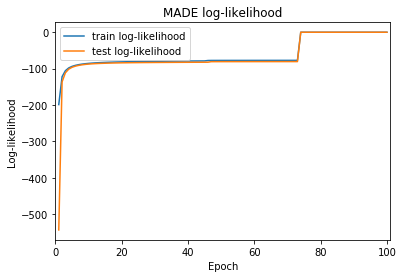

epoch 73
test epoch average loss: 80.668835


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.233836


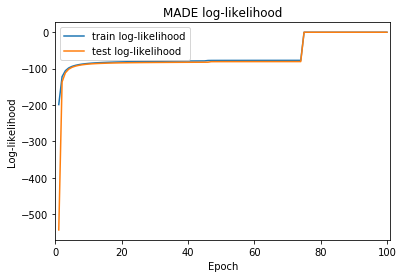

epoch 74
test epoch average loss: 80.663315


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.227027


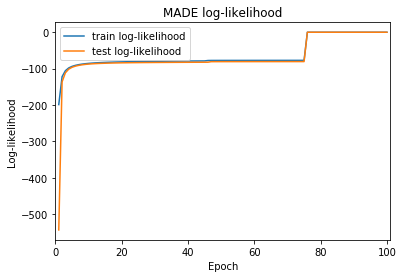

epoch 75
test epoch average loss: 80.658583


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.220212


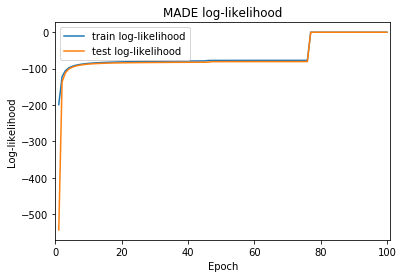

epoch 76
test epoch average loss: 80.654190


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.213436


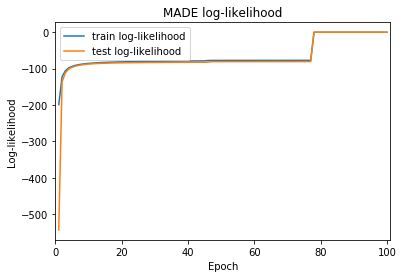

epoch 77
test epoch average loss: 80.650082


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.206605


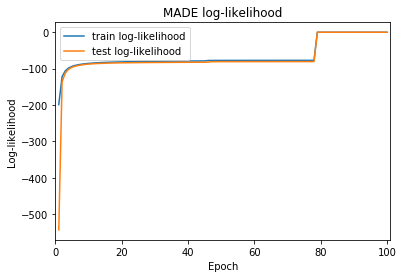

epoch 78
test epoch average loss: 80.646106


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.199759


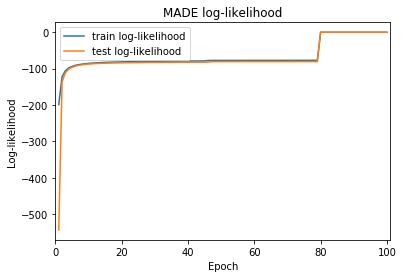

epoch 79
test epoch average loss: 80.640932


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.193050


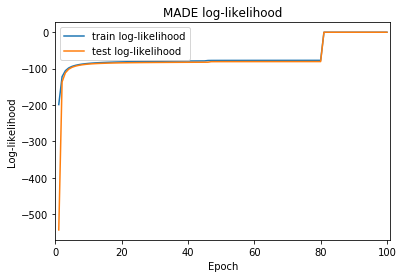

epoch 80
test epoch average loss: 80.636618


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.186315


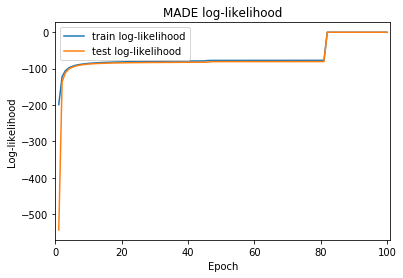

epoch 81
test epoch average loss: 80.632056


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.179608


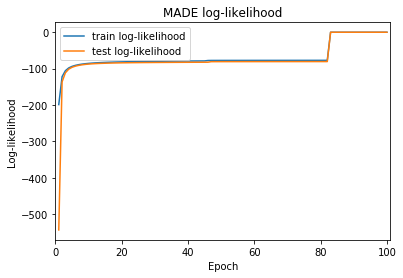

epoch 82
test epoch average loss: 80.627899


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.172935


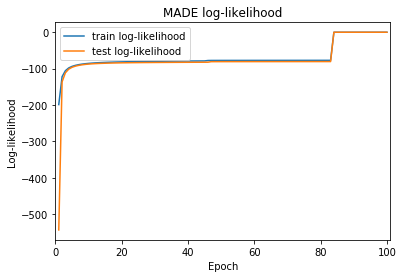

epoch 83
test epoch average loss: 80.623811


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.166285


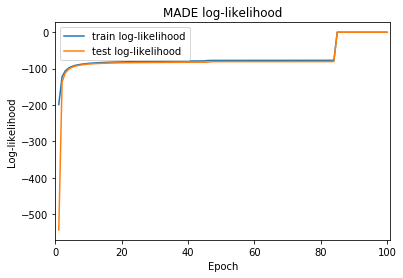

epoch 84
test epoch average loss: 80.618405


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.159649


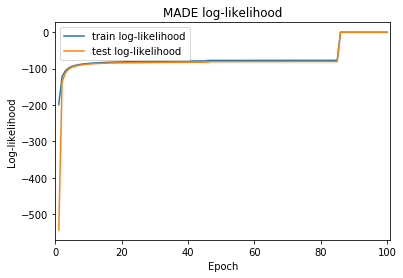

epoch 85
test epoch average loss: 80.615063


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.153038


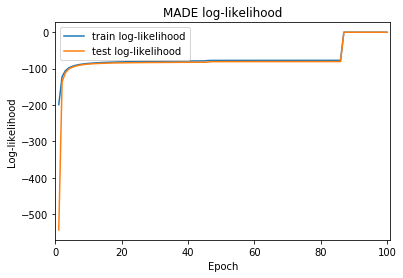

epoch 86
test epoch average loss: 80.610123


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.146446


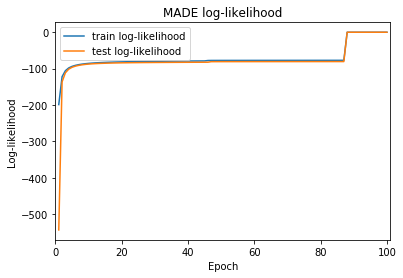

epoch 87
test epoch average loss: 80.606165


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.139937


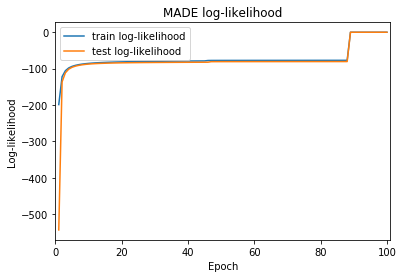

epoch 88
test epoch average loss: 80.601787


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.133438


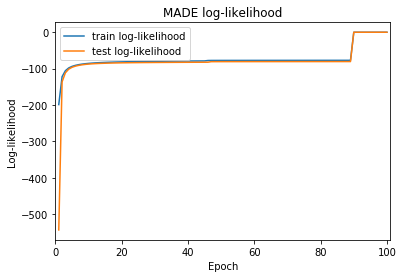

epoch 89
test epoch average loss: 80.598792


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 77.126903


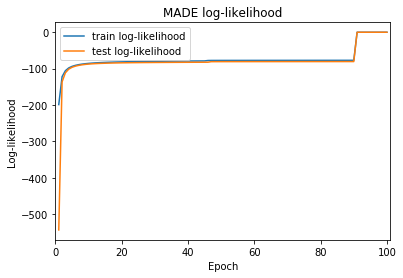

epoch 90
test epoch average loss: 80.594110


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.977976


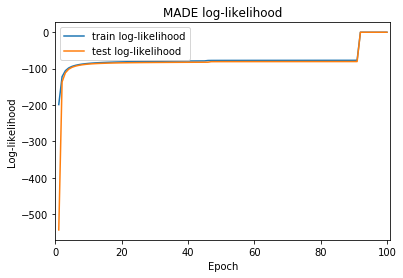

epoch 91
test epoch average loss: 80.503761


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.957070


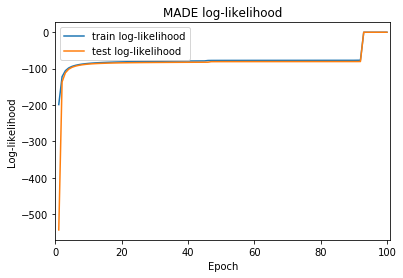

epoch 92
test epoch average loss: 80.501152


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.952926


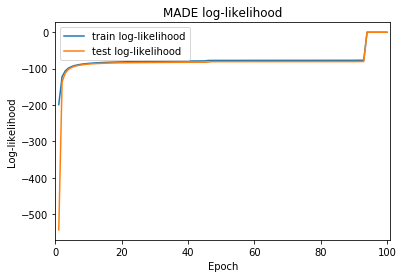

epoch 93
test epoch average loss: 80.499763


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.950627


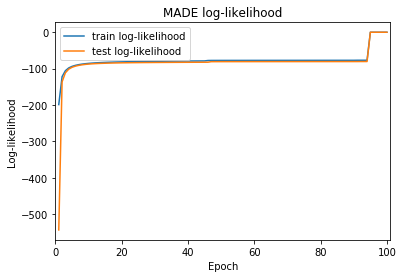

epoch 94
test epoch average loss: 80.498831


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.949010


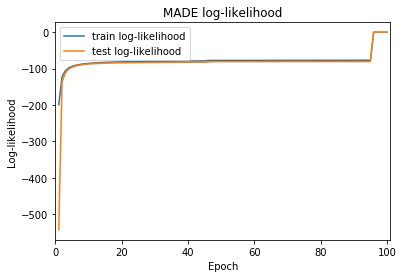

epoch 95
test epoch average loss: 80.498495


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.947679


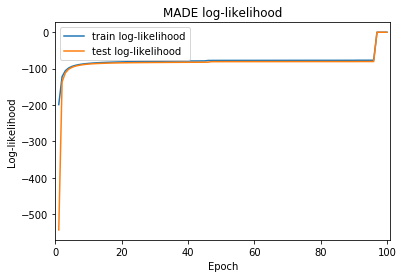

epoch 96
test epoch average loss: 80.497461


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.946559


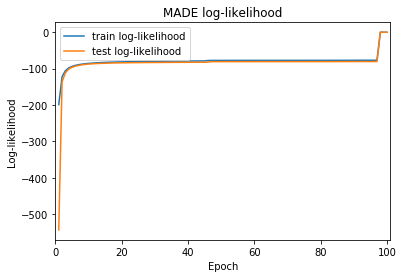

epoch 97
test epoch average loss: 80.497289


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.945568


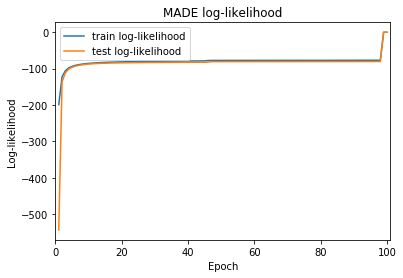

epoch 98
test epoch average loss: 80.496465


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.944629


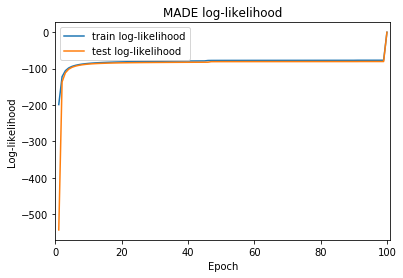

epoch 99
test epoch average loss: 80.496126


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train epoch average loss: 76.943713


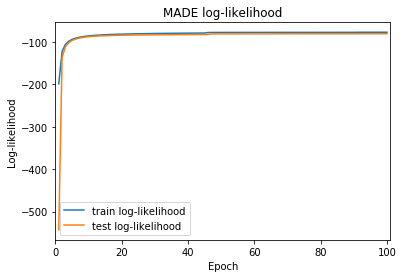

optimization done. full test set eval:


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


test epoch average loss: 79.783008


In [11]:
#### TRAINING:
#state_dict = torch.load('save/model_final.ckpt')
#model.load_state_dict(state_dict)

testL = np.zeros(num_epochs)
trainL = np.zeros(num_epochs)

for epoch in range(num_epochs):
    
    print("epoch %d" % (epoch, ))
    scheduler.step(epoch)
    run_epoch('test', upto=5) # run only a few batches for approximate test accuracy
    run_epoch('train')
    
    if (epoch+1) % 10 == 0:
        sample_64(epoch+1)
        torch.save(model.state_dict(), os.path.join('save', 'model--{}.ckpt'.format(epoch+1)))

    plt.figure()
    pylab.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), -trainL, label='train log-likelihood')
    plt.plot(range(1, num_epochs + 1), -testL, label='test log-likelihood')
    plt.legend()
    plt.title("MADE log-likelihood")
    plt.xlabel("Epoch")
    plt.ylabel("Log-likelihood")
    plt.savefig(os.path.join('save', 'loss.pdf'))
    plt.show()

torch.save(model.state_dict(), os.path.join('save', 'model_final.ckpt'))
print("optimization done. full test set eval:") # 79.72 my last experiment with 100 epochs!
if num_epochs > 0:
    run_epoch('test')

## 4. Nearest neighbors

In [ ]:
# NEAREST NEIGHBOUR!!!!!
# Images 28x28, search the closest one.
# function(generated_image) --> closest training_image

if NN == True:
    aux_data_loader = np.load(args["dtr_path"])

    def nearest_gt(generated_image):
        min_d = 0
        closest = False
        for i, image in enumerate(aux_data_loader):
            image = np.array(image).reshape(28,28) # all distances in binary...
            image = torch.tensor(image).float()
            d = torch.dist(generated_image,image) # must be torch tensors (1,28,28)
            if i == 0 or d < min_d:
                min_d = d
                closest = image

        return closest

    # calculate closest to...
    samples = torch.zeros(24, 1, 28, 28)
    NN = torch.zeros(24, 1, 28, 28)
    for i in range(0,24):
            image = torch.tensor(sample(i))
            samples[i] = image
            NN[i] = nearest_gt(samples[i])
            print(i)
    save_image(samples, 'f24.png')
    save_image(NN.data, 'NN24.png')

## 5. References

[1] https://github.com/karpathy/pytorch-made